#  성별에 따른 데이터 시각화 및 나이브 베이즈이론을 활용한 예약 이행 여부 예측
## 캐글  문제 : https://www.kaggle.com/joniarroba/noshowappointments
### 데이터

https://raw.githubusercontent.com/ZubairHussain/Appointment-No-Show-/master/No-show-Issue-Comma-300k.csv

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
!dir data

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 264E-2F1C

 C:\Users\rta_note\Desktop\DSAC_한남대_M1_20190624\한남대_Lab_M1\data 디렉터리

2019-06-19  오전 11:24    <DIR>          .
2019-06-19  오전 11:24    <DIR>          ..
2019-05-29  오후 09:26         1,127,225 airports.dat
2019-06-08  오후 08:20               184 coffee.csv
2019-06-19  오후 11:59           677,266 no_show.csv
2019-06-08  오후 07:28            19,816 radishsurvey.txt
2019-06-08  오후 08:23         2,377,148 routes.dat
2016-12-03  오전 04:29           503,663 spam.csv
2019-06-19  오후 08:57            56,621 test.png
2019-06-14  오전 11:33            31,744 시도별_용도별.xls
               8개 파일           4,793,667 바이트
               2개 디렉터리  205,508,354,048 바이트 남음


In [ ]:
!curl https://raw.githubusercontent.com/ZubairHussain/Appointment-No-Show-/master/No-show-Issue-Comma-300k.csv \
    -o .\data\no_show.csv

In [4]:
# !dir
# !mkdir data

In [4]:
data =  pd.read_csv("./data/no_show.csv")
data.head()

Age Gender AppointmentRegistration        ApointmentData DayOfTheWeek  \
0   19      M    2014-12-16T14:46:25Z  2015-01-14T00:00:00Z    Wednesday   
1   24      F    2015-08-18T07:01:26Z  2015-08-19T00:00:00Z    Wednesday   
2    4      F    2014-02-17T12:53:46Z  2014-02-18T00:00:00Z      Tuesday   
3    5      M    2014-07-23T17:02:11Z  2014-08-07T00:00:00Z     Thursday   
4   38      M    2015-10-21T15:20:09Z  2015-10-27T00:00:00Z      Tuesday   

    Status  Diabetes  Alcoolism  HiperTension  Handcap  Smokes  Scholarship  \
0  Show-Up       0.0        0.0           0.0      0.0     0.0          0.0   
1  Show-Up       0.0        0.0           0.0      0.0     0.0          0.0   
2  Show-Up       0.0        0.0           0.0      0.0     0.0          0.0   
3  Show-Up       0.0        0.0           0.0      0.0     0.0          0.0   
4  Show-Up       0.0        0.0           0.0      0.0     0.0          0.0   

   Tuberculosis  Sms_Reminder  AwaitingTime  
0           0.0           0.0         -29.0  
1           0.0           0.0          -1.0  
2           0.0           0.0          -1.0  
3           0.0           1.0         -15.0  
4           0.0           1.0          -6.0

# 1. 데이터 점검

### 1.1 데이터 정리 및 오타 제거

일부 column의 오타를 알맞게 고치고 예약 등록날과 예약된 날의 간격의 수를 양수로 바꾸어준다.  

In [5]:
data.columns

Index(['Age', 'Gender', 'AppointmentRegistration', 'ApointmentData',
       'DayOfTheWeek', 'Status', 'Diabetes', 'Alcoolism', 'HiperTension',
       'Handcap', 'Smokes', 'Scholarship', 'Tuberculosis', 'Sms_Reminder',
       'AwaitingTime'],
      dtype='object')

In [6]:
data.rename(columns = {'ApointmentData':'AppointmentData', 'Alcoolism': 'Alcoholism', #철자가 틀린것을 고치기
                         'HiperTension': 'Hypertension', 'Handcap': 'Handicap'}, inplace = True) 

data.head(5)     

Age Gender AppointmentRegistration       AppointmentData DayOfTheWeek  \
0   19      M    2014-12-16T14:46:25Z  2015-01-14T00:00:00Z    Wednesday   
1   24      F    2015-08-18T07:01:26Z  2015-08-19T00:00:00Z    Wednesday   
2    4      F    2014-02-17T12:53:46Z  2014-02-18T00:00:00Z      Tuesday   
3    5      M    2014-07-23T17:02:11Z  2014-08-07T00:00:00Z     Thursday   
4   38      M    2015-10-21T15:20:09Z  2015-10-27T00:00:00Z      Tuesday   

    Status  Diabetes  Alcoholism  Hypertension  Handicap  Smokes  Scholarship  \
0  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
1  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
2  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
3  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
4  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   

   Tuberculosis  Sms_Reminder  AwaitingTime  
0           0.0           0.0         -29.0  
1           0.0           0.0          -1.0  
2           0.0           0.0          -1.0  
3           0.0           1.0         -15.0  
4           0.0           1.0          -6.0

In [7]:
data.AwaitingTime = data.AwaitingTime.apply(abs) #등록날과 예약된 날의 간격이 음수로 되어있는데 이것을 절대값을 씌어주어 양수로 고쳐준다
print(data.AwaitingTime.head())

0    29.0
1     1.0
2     1.0
3    15.0
4     6.0
Name: AwaitingTime, dtype: float64


###  1.2  에러 체크 및 제거
데이터를 확인하여 NAN이나 맞지 않는 값을 찾아내 제거한다.

In [9]:
# pd.Series([2,1,3,3]).unique()

array([2, 1, 3], dtype=int64)

In [8]:
print('Age:',sorted(data.Age.unique())) # 각 데이터들의 잘못된 값이나 NAN값을 확인한다 SORTED는 값을 정렬해주고 
print('Gender:',data.Gender.unique())   # unique는 중복없이 값을 보여준다
print('DayOfTheWeek:',data.DayOfTheWeek.unique())
print('Status:',data.Status.unique())
print('Diabetes:',data.Diabetes.unique())
print('Alcoholism:',data.Alcoholism.unique())
print('Hypertension:',data.Hypertension.unique())
print('Handicap:',data.Handicap.unique())
print('Smokes:',data.Smokes.unique())
print('Scholarship:',data.Scholarship.unique())
print('Tuberculosis:',data.Tuberculosis.unique())
print('Sms_Reminder:',data.Sms_Reminder.unique())
print('AwaitingTime:',sorted(data.AwaitingTime.unique()))

Age: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 101, 104]
Gender: ['M' 'F']
DayOfTheWeek: ['Wednesday' 'Tuesday' 'Thursday' 'Friday' 'Monday' 'Saturday' nan]
Status: ['Show-Up' 'No-Show' nan]
Diabetes: [ 0.  1. nan]
Alcoholism: [ 0.  1. nan]
Hypertension: [ 0.  1. nan]
Handicap: [ 0.  1.  2.  3. nan]
Smokes: [ 0.  1. nan]
Scholarship: [ 0.  1. nan]
Tuberculosis: [ 0.  1. nan]
Sms_Reminder: [ 0.  1.  2. nan]
AwaitingTime: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 4

-1과 -2같이 잘못된 나이와 데이터 정리를 위해 100세 이상의 나이를 모두 제거 한다

In [9]:
data = data[(data.Age >= 0) & (data.Age <= 100)]

###  1.3  전체 객체에서 남자 여자 비율  및 예약 이행 비율 확인

In [10]:
pd.crosstab(index = data['Gender'], columns = data['Status'])   # cross tabulation (그룹화할 행과 열 지정)

Status  No-Show  Show-Up
Gender                  
F          1648     3812
M           822     1916

In [12]:
# pd.crosstab(index = data.Gender, columns = data.Status)   # same result

In [13]:
pd.crosstab(index = data['Gender'], columns = data.Status).reset_index()

Status Gender  No-Show  Show-Up
0           F     1648     3812
1           M      822     1916

In [14]:
df = pd.crosstab(index = data['Gender'], columns = data.Status).reset_index()    # cross tabulation
##crosstab은 그룹화할 행을 인덱스에 그룹화할 열을 columns에 넣고 각 행에 따른 Column의 개수를 보여준다
df['Sum']= pd.DataFrame([((data['Gender']== 'F').sum()), ((data['Gender']== 'M').sum())])                      
df

Status Gender  No-Show  Show-Up   Sum
0           F     1648     3812  5461
1           M      822     1916  2738

In [15]:
all_oj = (data['Gender']== 'M').sum() + (data['Gender']== 'F').sum()  # 전체 객체수
print("Man : ", round((data['Gender']== 'M').sum() /all_oj , 4)*100 , '%')  #round는 퍼센트를 구할때 유용한 라이브러리로 , 5는 5개의 자리를 
print("Woman : ", round((data['Gender']== 'F').sum() /all_oj , 4)*100 , '%') # 나타낸다는 것을 의미한다

Man :  33.39 %
Woman :  66.61 %


In [16]:
FM = data[(data['Gender']== 'F')]  #여자만 있는 데이터프레임 생성
f_oj = (data['Gender']== 'F').sum()  # 여자 객체수

# FM.head()

print("WoMan No-Show : ", round((FM['Status']== 'No-Show').sum() /f_oj , 5)*100 , '%')  # 여자가 예약 이행 안한 비율
print("WoMan Show-up : ", 100-round((FM['Status']== 'No-Show').sum() /f_oj , 5)*100 , '%')  # 여자가 예약 이행 한 비율
print("WoMan Show-up : ", round((FM['Status']== 'Show-Up').sum() /f_oj , 5)*100 , '%')

WoMan No-Show :  30.178 %
WoMan Show-up :  69.822 %
WoMan Show-up :  69.804 %


In [17]:
MM = data[(data['Gender']== 'M')] #남자만 있는 데이터프레임 생성
m_oj = (data['Gender']== 'M').sum()  # 남자 객체수
print("Man No-Show : ", round((MM['Status']== 'No-Show').sum() /m_oj , 5)*100 , '%')  # 남자가 예약 이행 안한 비율
print("Man Show-up : ", 100-round((MM['Status']== 'No-Show').sum() /m_oj , 5)*100 , '%') # 남자가 예약 이행 한 비율

Man No-Show :  30.022 %
Man Show-up :  69.97800000000001 %


# 2. 데이터 탐구

### 2.1 여러가지 데이터를 이용하여 남자와 여자 예약 이행 여부 시각화 

#### 나이에 따른 예약 이행 여부 시각화

In [18]:
# special function lambda (): 이름 없는 함수 (: 앞뒨에 입력과 출력 값 지정)
# 일회성 함수로 주로 함수를 함수의 인자로 넣을 때 사용
def add(x,y):
    return x+y
f = lambda x,y: x+y     # 이름을 줄 수도 있음
add(3,4), f(3,4)

(7, 7)

### my version (not using lambda functions)

In [19]:
# my own version (not using lambda functions)
df = data[data.Status == 'Show-Up'] ## 예약 이행한 것만 추출후 df에 저장
df2 = pd.DataFrame()  
df2['Men'] = range(100)
df2['Women'] = range(100)

In [20]:
df.head()

Age Gender AppointmentRegistration       AppointmentData DayOfTheWeek  \
0   19      M    2014-12-16T14:46:25Z  2015-01-14T00:00:00Z    Wednesday   
1   24      F    2015-08-18T07:01:26Z  2015-08-19T00:00:00Z    Wednesday   
2    4      F    2014-02-17T12:53:46Z  2014-02-18T00:00:00Z      Tuesday   
3    5      M    2014-07-23T17:02:11Z  2014-08-07T00:00:00Z     Thursday   
4   38      M    2015-10-21T15:20:09Z  2015-10-27T00:00:00Z      Tuesday   

    Status  Diabetes  Alcoholism  Hypertension  Handicap  Smokes  Scholarship  \
0  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
1  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
2  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
3  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
4  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   

   Tuberculosis  Sms_Reminder  AwaitingTime  
0           0.0           0.0          29.0  
1           0.0           0.0           1.0  
2           0.0           0.0           1.0  
3           0.0           1.0          15.0  
4           0.0           1.0           6.0

In [21]:
df2.head()

Men  Women
0    0      0
1    1      1
2    2      2
3    3      3
4    4      4

In [22]:
for x in range(100):
    df2.Men[x] = len(df[(df.Age == x) & (df.Gender == 'M')])
    df2.Women[x] = len(df[(df.Age == x) & (df.Gender == 'F')])

In [23]:
df2.head()

Men  Women
0  113     83
1   48     33
2   25     20
3   32     21
4   43     26

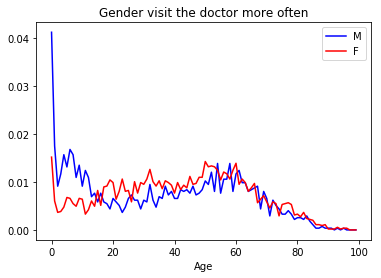

In [24]:
plt.xlabel('Age') # X축의 이름 
plt.title('Gender visit the doctor more often') #그래프의 이름 설정
plt.plot(range(100),df2.Men/(data['Gender']== 'M').sum(), 'b') #남자의 연령별 예약 이행 비율
plt.plot(range(100),df2.Women/(data['Gender']== 'F').sum(), color = 'r') #여자의 연령별 예약 이행 비율
plt.legend(['M','F'])
plt.show()

### original version (text)

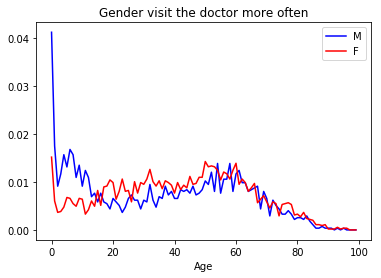

In [25]:
df = data[data.Status == 'Show-Up'] ## 예약 이행한 것만 추출후 df에 저장
range_df = pd.DataFrame()    
range_df['Age'] = range(100)

men = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'M')]))  #이름없는함수이며 일회용으로 사용된다 
women = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'F')]))
plt.xlabel('Age') # X축의 이름 
plt.title('Gender visit the doctor more often') #그래프의 이름 설정
plt.plot(range(100),men/(data['Gender']== 'M').sum(), 'b') #남자의 연령별 예약 이행 비율
plt.plot(range(100),women/(data['Gender']== 'F').sum(), color = 'r') #여자의 연령별 예약 이행 비율
plt.legend(['M','F'])
plt.show()

In [26]:
df2.Men.values, men.values

(array([113,  48,  25,  32,  43,  36,  46,  43,  30,  37,  25,  34,  30,
         19,  21,  16,  21,  16,  15,  12,  18,  16,  14,  10,  13,  18,
         20,  17,  17,  12,  17,  16,  26,  17,  13,  19,  18,  25,  20,
         22,  18,  18,  23,  22,  23,  21,  25,  20,  21,  23,  28,  26,
         33,  22,  38,  21,  29,  29,  38,  22,  32,  34,  27,  27,  22,
         23,  24,  25,  12,  22,  18,   8,  17,  14,  12,   9,   9,  11,
          9,   6,   7,   7,   6,   8,   5,   3,   1,   1,   2,   1,   1,
          1,   0,   1,   0,   1,   0,   0,   0,   0]),
 array([113,  48,  25,  32,  43,  36,  46,  43,  30,  37,  25,  34,  30,
         19,  21,  16,  21,  16,  15,  12,  18,  16,  14,  10,  13,  18,
         20,  17,  17,  12,  17,  16,  26,  17,  13,  19,  18,  25,  20,
         22,  18,  18,  23,  22,  23,  21,  25,  20,  21,  23,  28,  26,
         33,  22,  38,  21,  29,  29,  38,  22,  32,  34,  27,  27,  22,
         23,  24,  25,  12,  22,  18,   8,  17,  14,  12,   9,   9,  

In [27]:
type(df2.Men), type(men)

(pandas.core.series.Series, pandas.core.series.Series)

#### 각종 질병 발생 시에 남녀 예약 이행 비율

In [28]:
men_smoke = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'M') & (df.Smokes == 1)])) #남자이며 흡연자
women_smoke = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'F') & (df.Smokes == 1)])) #여자이며 흡연자

men_tension = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'M') & (df.Hypertension == 1)])) #남자이며 고혈압
women_tension = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'F') & (df.Hypertension == 1)])) #여자이며 고혈압
 
men_Diabetes = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'M') & (df.Diabetes == 1)])) #남자이며 당뇨병
women_Diabetes = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'F') & (df.Diabetes == 1)])) #여자이며 당뇨병

men_Tuber = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'M') & (df.Tuberculosis == 1)])) #남자이며 결핵
women_Tuber = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'F') & (df.Tuberculosis == 1)]))#여자이며 결핵

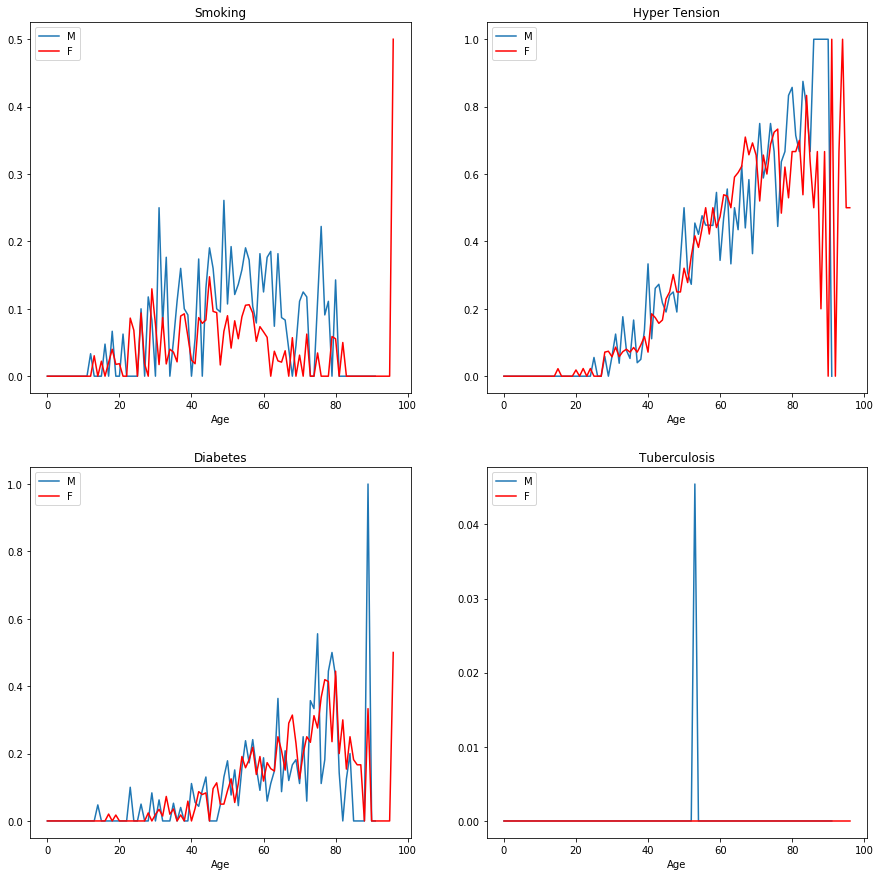

In [29]:
plt.figure(figsize = (15,15))        ## 그래프 사이즈
plt.subplot(221)                     ## 행 열 그리고 그 행열에 위치 
plt.plot(range(100),men_smoke/men)   # 세로축을 비율로 만들기위해 (나이별로) 전체 남자에서 남자흡연자를 나눈다.
plt.plot(range(100),women_smoke/women, color = 'r')
plt.title('Smoking') #제목
plt.legend(['M','F'], loc = 2)
plt.xlabel('Age')           

plt.subplot(222)
plt.plot(range(100),men_tension/men)
plt.plot(range(100),women_tension/women, color = 'r')
plt.title('Hyper Tension')
plt.legend(['M','F'], loc = 2)
plt.xlabel('Age')

plt.subplot(223)
plt.plot(range(100),men_Diabetes/men)
plt.plot(range(100),women_Diabetes/women, color = 'r')
plt.title('Diabetes')
plt.legend(['M','F'], loc = 2)
plt.xlabel('Age')

plt.subplot(224)
plt.plot(range(100),men_Tuber/men)
plt.plot(range(100),women_Tuber/women, color = 'r')
plt.legend(['M','F'], loc = 2)
plt.xlabel('Age')

plt.title('Tuberculosis')
plt.show()

In [30]:
men_smoke.head(), men.head()

(0    0
 1    0
 2    0
 3    0
 4    0
 Name: Age, dtype: int64, 0    113
 1     48
 2     25
 3     32
 4     43
 Name: Age, dtype: int64)

대부분의 질병은 남녀 비율이 비슷하지만  결핵에 한해서는 남자의 비율이 높다

#### 예약 등록날과 예약 당일날과의 차이(간격)

In [31]:
bins = [0, 2, 7, 14, 30, 90, 180, 9999] # 예약 시간과의 공백이 막연히 숫자로 만 되어있어서 문자로 만들어주기위한 기준배열
labels = ["Immediate", "Week" ,"Two Weeks", "Month", "Trimester" , "Half year" , "Forever"]

In [32]:
# cut는 한 column에서 리스트를 사용하여 기준을 나눈다.
wait_period = pd.cut(data.AwaitingTime, bins, labels=labels)

In [33]:
wait_period.head()

0        Month
1    Immediate
2    Immediate
3        Month
4         Week
Name: AwaitingTime, dtype: category
Categories (7, object): [Immediate < Week < Two Weeks < Month < Trimester < Half year < Forever]

In [34]:
data['Wait_period'] = wait_period # 새로운 column을 만들어 이것을 넣고 예약 이행자들만 추출한다
df = data[data.Status == 'Show-Up']
wait_df =  pd.DataFrame(labels) 

In [35]:
wait_df

0
0  Immediate
1       Week
2  Two Weeks
3      Month
4  Trimester
5  Half year
6    Forever

In [36]:
men_wait = wait_df[wait_df.columns[0]].apply(lambda x: len(df[(df.Wait_period == x) & (df.Gender == 'M')])) 
women_wait = wait_df[wait_df.columns[0]].apply(lambda x: len(df[(df.Wait_period == x) & (df.Gender == 'F')]))

In [37]:
men_wait, women_wait

(0    389
 1    588
 2    327
 3    404
 4    197
 5     10
 6      1
 Name: 0, dtype: int64, 0     799
 1    1119
 2     607
 3     871
 4     398
 5      18
 6       0
 Name: 0, dtype: int64)

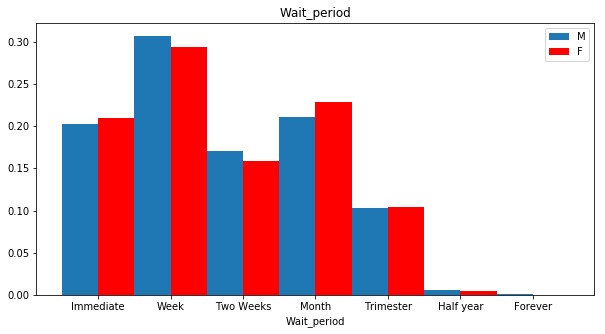

In [38]:
plt.figure(figsize = (10,5)) # 그래프 사이즈
plt.bar(range(7), men_wait/len(df[df.Gender == 'M']), width = 0.5)  #막대를 7개만들고 막대 크기를 0.5로한다 
plt.bar(range(7)+0.5*np.ones(len(range(7))), women_wait/len(df[df.Gender == 'F']), width = 0.5, color = 'r')
plt.xticks(range(7) + 0.25*np.ones(len(range(7))), labels)  # x축의 라벨 삽입

plt.title('Wait_period')
plt.xlabel('Wait_period')
plt.legend(['M','F'])
plt.show()

#### 어떤 요일을 가장 많이 선호하는가에 대한 시각화

In [39]:
Days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']  # 요일을 리스트로 만든다
Days_df = pd.DataFrame(Days)  #그것을 데이터 프레임으로 만든다

In [40]:
Days_df

0
0     Monday
1    Tuesday
2  Wednesday
3   Thursday
4     Friday
5   Saturday
6     Sunday

In [41]:
men_days = Days_df[Days_df.columns[0]].apply(lambda x: len(df[(df.DayOfTheWeek == x) & (df.Gender == 'M')]))
women_days = Days_df[Days_df.columns[0]].apply(lambda x: len(df[(df.DayOfTheWeek == x) & (df.Gender == 'F')]))

In [42]:
men_days

0    384
1    384
2    425
3    379
4    338
5      6
6      0
Name: 0, dtype: int64

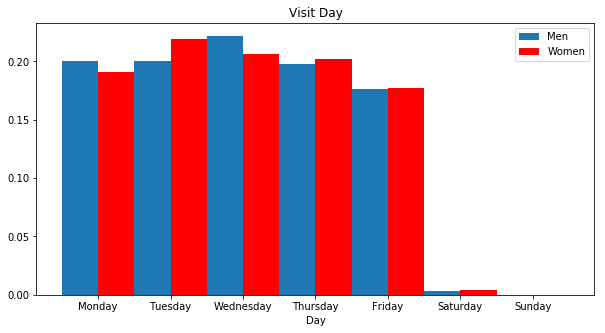

In [43]:
plt.figure(figsize = (10,5))
plt.bar(range(7), men_days/len(df[df.Gender == 'M']), width = 0.5)
plt.bar(range(7)+0.5*np.ones(len(range(7))), women_days/len(df[df.Gender == 'F']), width = 0.5, color = 'r')
plt.xticks(range(7) + 0.25*np.ones(len(range(7))),Days)

plt.title('Visit Day')
plt.xlabel('Day')
plt.legend(['Men','Women'])
plt.show()

예약 공백기간에서 남자들은 최근 예약을 잘 이행하는 반면에 여자들은 오래 된 예약을 더 잘 지키는 경향이 있다
요일 같은 경우에는 주말에 멀수록 예약자들이 많았고 남녀 비율은 요일마다 들쭉날쭉하므로 큰 영향이 없어보였다.

#### 월 별 예약 이행자에 대한 시각화

In [44]:
dts = data.copy() #데이터복사를 한 이유는 원본 데이터가 들어있는 변수에 영향을 주지 않기위함이다
dts.head()

Age Gender AppointmentRegistration       AppointmentData DayOfTheWeek  \
0   19      M    2014-12-16T14:46:25Z  2015-01-14T00:00:00Z    Wednesday   
1   24      F    2015-08-18T07:01:26Z  2015-08-19T00:00:00Z    Wednesday   
2    4      F    2014-02-17T12:53:46Z  2014-02-18T00:00:00Z      Tuesday   
3    5      M    2014-07-23T17:02:11Z  2014-08-07T00:00:00Z     Thursday   
4   38      M    2015-10-21T15:20:09Z  2015-10-27T00:00:00Z      Tuesday   

    Status  Diabetes  Alcoholism  Hypertension  Handicap  Smokes  Scholarship  \
0  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
1  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
2  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
3  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
4  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   

   Tuberculosis  Sms_Reminder  AwaitingTime Wait_period  
0           0.0           0.0          29.0       Month  
1           0.0           0.0           1.0   Immediate  
2           0.0           0.0           1.0   Immediate  
3           0.0           1.0          15.0       Month  
4           0.0           1.0           6.0        Week

In [45]:
# dts.AppointmentData.head() , dts['AppointmentData'].head()

In [46]:
dts['AppointmentData'][0][:15]

'2015-01-14T00:0'

In [47]:
dts['Month'] = dts['AppointmentData'].apply(lambda x: x[5:7]) # 5:7은  날짜에서 월만 추출한다는것이다 
dts = dts[dts.Status == 'Show-Up']
dts= dts[["Month","Gender"]]

In [48]:
dts.head()

Month Gender
0    01      M
1    08      F
2    02      F
3    08      M
4    10      M

In [49]:
dts = pd.crosstab(index = dts['Month'], columns = dts.Gender) #월을 인덱스에 컬럼에 성별을 넣는 새로운 데이터프레임 생성

In [50]:
dts

Gender    F    M
Month           
01      296  144
02      302  130
03      318  167
04      300  139
05      340  175
06      359  147
07      315  181
08      318  160
09      315  186
10      341  164
11      336  182
12      272  141

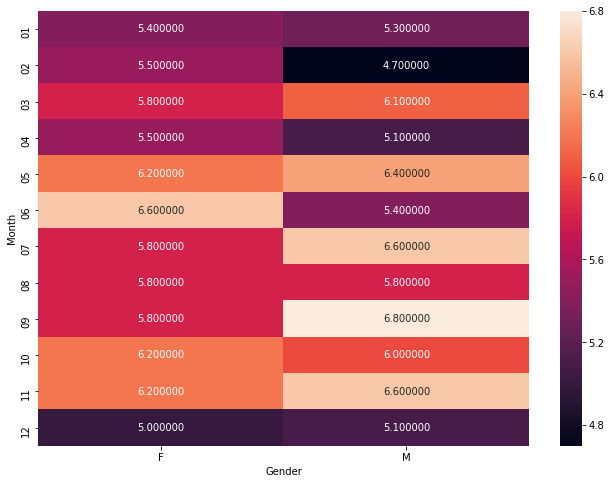

In [51]:
dts['F'] = round((dts['F']/f_oj),3) *100
dts['M'] = round((dts['M']/m_oj),3) *100
plt.figure(figsize=(11,8))
sns.heatmap(dts, annot=True, fmt='f') ##annot는 각 셀에 값을 표시할지 여부 fmt는 표현 방식 f는 실수형 
plt.show()

병원 이용객은 여름 가을에 가장 많았으며 특히 휴가철인 7월에 절정을 찍었다. 하지만 남녀의 차이에는 큰 영향이 없었다.

#### 하루 중에 어떤 시간에 가장 많이 예약을 등록하러 오는지에 대한 시각화

In [52]:
data.head()

Age Gender AppointmentRegistration       AppointmentData DayOfTheWeek  \
0   19      M    2014-12-16T14:46:25Z  2015-01-14T00:00:00Z    Wednesday   
1   24      F    2015-08-18T07:01:26Z  2015-08-19T00:00:00Z    Wednesday   
2    4      F    2014-02-17T12:53:46Z  2014-02-18T00:00:00Z      Tuesday   
3    5      M    2014-07-23T17:02:11Z  2014-08-07T00:00:00Z     Thursday   
4   38      M    2015-10-21T15:20:09Z  2015-10-27T00:00:00Z      Tuesday   

    Status  Diabetes  Alcoholism  Hypertension  Handicap  Smokes  Scholarship  \
0  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
1  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
2  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
3  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
4  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   

   Tuberculosis  Sms_Reminder  AwaitingTime Wait_period  
0           0.0           0.0          29.0       Month  
1           0.0           0.0           1.0   Immediate  
2           0.0           0.0           1.0   Immediate  
3           0.0           1.0          15.0       Month  
4           0.0           1.0           6.0        Week

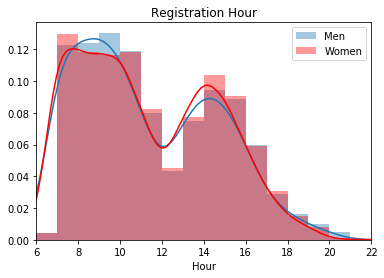

In [53]:
data['Time'] = data['AppointmentRegistration'].apply(lambda x: int(x[11:13])) ##커널밀도 추정 히스토그램을 스무디하게 평활화
                                                                              ##  (distribution plot)
# sns.distplot(data.Time[data.Gender == 'M'], bins = range(24),norm_hist = True, kde = False)   # histogram shows a density (not a count)
# sns.distplot(data.Time[data.Gender == 'F'], bins = range(24),norm_hist = True, kde = False, color = 'r')
                                                    ##norm_hist y의 값을 퍼센트값

sns.distplot(data.Time[data.Gender == 'M'], bins = range(24),norm_hist = True)   # histogram shows a density (not a count)
sns.distplot(data.Time[data.Gender == 'F'], bins = range(24),norm_hist = True, color = 'r')
plt.xlim([6,22]) # x축 범위 설정 병원이 6시부터 22시까지 운영하기 때문이다
plt.title('Registration Hour')
plt.xlabel('Hour')
plt.legend(['Men','Women'])
plt.show()

남자들은 주로 아침에 많이 예약을 등록하고 여자는 낮에 많이 예약을 등록한다 

### 2.2 두 가지 질병을 가진 사람의 예약 이행 여부 비교

지금까지는 한 가지의 조건만으로 비교했는데 이번엔 알코올 의존증과 폐암을 동시에 비교한다

In [54]:
data2 = data.copy() 
data2.eval("Show = Status == 'Show-Up'", inplace=True) # inplace는 새 dataframe을 반환할지 기존 것을 변경할지말이다
                                                        # 기본적으로 false로 설정된다
data2.eval("No = Status == 'No-Show'", inplace=True)   # eval은 파이썬 표현식만 포함 가능하다

In [55]:
data.head(3)

Age Gender AppointmentRegistration       AppointmentData DayOfTheWeek  \
0   19      M    2014-12-16T14:46:25Z  2015-01-14T00:00:00Z    Wednesday   
1   24      F    2015-08-18T07:01:26Z  2015-08-19T00:00:00Z    Wednesday   
2    4      F    2014-02-17T12:53:46Z  2014-02-18T00:00:00Z      Tuesday   

    Status  Diabetes  Alcoholism  Hypertension  Handicap  Smokes  Scholarship  \
0  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
1  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
2  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   

   Tuberculosis  Sms_Reminder  AwaitingTime Wait_period  Time  
0           0.0           0.0          29.0       Month    14  
1           0.0           0.0           1.0   Immediate     7  
2           0.0           0.0           1.0   Immediate    12

In [56]:
data2.head(3)

Age Gender AppointmentRegistration       AppointmentData DayOfTheWeek  \
0   19      M    2014-12-16T14:46:25Z  2015-01-14T00:00:00Z    Wednesday   
1   24      F    2015-08-18T07:01:26Z  2015-08-19T00:00:00Z    Wednesday   
2    4      F    2014-02-17T12:53:46Z  2014-02-18T00:00:00Z      Tuesday   

    Status  Diabetes  Alcoholism  Hypertension  Handicap  Smokes  Scholarship  \
0  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
1  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
2  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   

   Tuberculosis  Sms_Reminder  AwaitingTime Wait_period  Time  Show     No  
0           0.0           0.0          29.0       Month    14  True  False  
1           0.0           0.0           1.0   Immediate     7  True  False  
2           0.0           0.0           1.0   Immediate    12  True  False

In [57]:
# groupby 연습
df = pd.DataFrame({'Animal' : ['Falcon', 'Falcon', 'Parrot', 'Parrot'],
                   'Max Speed' : [380., 370., 24., 26.]})
df

Animal  Max Speed
0  Falcon      380.0
1  Falcon      370.0
2  Parrot       24.0
3  Parrot       26.0

In [58]:
df.groupby(['Animal']).mean()

Max Speed
Animal           
Falcon      375.0
Parrot       25.0

In [59]:
groups = data2[['Gender', 'Smokes', 'Alcoholism', "Show", "No"]].groupby(['Gender', 'Smokes', 'Alcoholism'])
gps = pd.DataFrame(groups.mean())

In [62]:
gps

Show        No
Gender Smokes Alcoholism                    
F      0.0    0.0         0.702640  0.297360
              1.0         0.525000  0.475000
       1.0    0.0         0.640187  0.359813
              1.0         0.629630  0.370370
M      0.0    0.0         0.702290  0.297710
              1.0         0.564516  0.435484
       1.0    0.0         0.711538  0.288462
              1.0         0.710843  0.289157

In [63]:
groups.sum()

Show      No
Gender Smokes Alcoholism                
F      0.0    0.0         3620.0  1532.0
              1.0           21.0    19.0
       1.0    0.0          137.0    77.0
              1.0           34.0    20.0
M      0.0    0.0         1748.0   741.0
              1.0           35.0    27.0
       1.0    0.0           74.0    30.0
              1.0           59.0    24.0

In [64]:
gps["No-count"] = groups.sum()["No"]    # 예약 불 이행자의 객체수를 더한다
gps["Sh-count"] = groups.sum()["Show"]  # 예약 이행자의 객체수를 더한다
gps

Show        No  No-count  Sh-count
Gender Smokes Alcoholism                                        
F      0.0    0.0         0.702640  0.297360    1532.0    3620.0
              1.0         0.525000  0.475000      19.0      21.0
       1.0    0.0         0.640187  0.359813      77.0     137.0
              1.0         0.629630  0.370370      20.0      34.0
M      0.0    0.0         0.702290  0.297710     741.0    1748.0
              1.0         0.564516  0.435484      27.0      35.0
       1.0    0.0         0.711538  0.288462      30.0      74.0
              1.0         0.710843  0.289157      24.0      59.0

In [65]:
### exercise for groupby
df = pd.DataFrame({'A': [1, 1, 2, 1, 2],
                   'B': [np.nan, 2, 3, 4, 5],
                   'C': [1, 2, 1, 1, 2]}, columns=['A', 'B', 'C'])
df

A    B  C
0  1  NaN  1
1  1  2.0  2
2  2  3.0  1
3  1  4.0  1
4  2  5.0  2

In [66]:
df.groupby('A').mean()

B         C
A               
1  3.0  1.333333
2  4.0  1.500000

In [67]:
df.groupby('A').sum()

B  C
A        
1  6.0  4
2  8.0  3

In [68]:
df.groupby(['A', 'B']).mean()

C
A B     
1 2.0  2
  4.0  1
2 3.0  1
  5.0  2

In [73]:
df.groupby('A').mean()

B         C
A               
1  3.0  1.333333
2  4.0  1.500000

In [74]:
df.groupby('A').mean()['B']

A
1    3.0
2    4.0
Name: B, dtype: float64

In [75]:
df.groupby('A')['B'].mean()

A
1    3.0
2    4.0
Name: B, dtype: float64

신기하게도 두 가지 병을 앓고 있는 사람들의 예약 이행 비율이 건강한사람들보다 더 작았고 이것은 남녀 모두에게 나타났다.

#### 밀접한 관계의 합병증

당뇨병을 앓고 있는 사람들은 고혈압을, 고혈압을 가지고 있는 사람들은 당뇨병을 가지고 있는 경우가 많은데 그 만큼 두 가지의 병의 관계는 깊다. 그래서 이번엔 밀접한 관계에 있는 두 가지의 병을 묶어서 수치를 계산해 보았다.

In [76]:
groups = data2[['Gender','Hypertension','Diabetes', "Show", "No"]].groupby(['Gender','Hypertension','Diabetes'])
gps = pd.DataFrame(groups.mean())
gps["No-count"] = groups.sum()["No"]
gps["Sh-count"] = groups.sum()["Show"]
gps

Show        No  No-count  Sh-count
Gender Hypertension Diabetes                                        
F      0.0          0.0       0.682382  0.317618    1307.0    2808.0
                    1.0       0.634921  0.365079      23.0      40.0
       1.0          0.0       0.751425  0.248575     218.0     659.0
                    1.0       0.753086  0.246914     100.0     305.0
M      0.0          0.0       0.681440  0.318560     690.0    1476.0
                    1.0       0.694444  0.305556      11.0      25.0
       1.0          0.0       0.771208  0.228792      89.0     300.0
                    1.0       0.782313  0.217687      32.0     115.0

밀접한 관계에 있는 당뇨와 고혈압의 경우에는 위와는 정반대로 약속 이행 비율이 더 높게 나타났다 이것 또한 남녀 모두에게 나타났다

# 3. 데이터 예측

코드 출처 https://www.kaggle.com/somrikbanerjee/d/joniarroba/noshowappointments/predicting-show-up-no-show

먼저 반의 데이터로 기계학습을 한 뒤에 이것을 기반으로 나머지 반의 데이터의 예약 이행 여부 확률을 구한다

남자의 경우는 홀수개의 데이터이기 때문에 하나를 제외한다

In [87]:
FM.describe(), MM.describe()

(              Age     Diabetes   Alcoholism  Hypertension     Handicap  \
 count  5461.00000  5460.000000  5460.000000   5460.000000  5460.000000   
 mean     40.01703     0.085714     0.017216      0.234799     0.015568   
 std      21.69924     0.279967     0.130088      0.423912     0.130996   
 min       0.00000     0.000000     0.000000      0.000000     0.000000   
 25%      23.00000     0.000000     0.000000      0.000000     0.000000   
 50%      40.00000     0.000000     0.000000      0.000000     0.000000   
 75%      56.00000     0.000000     0.000000      0.000000     0.000000   
 max      96.00000     1.000000     1.000000      1.000000     2.000000   
 
             Smokes  Scholarship  Tuberculosis  Sms_Reminder  AwaitingTime  
 count  5460.000000  5460.000000   5460.000000   5460.000000   5460.000000  
 mean      0.049084     0.121612      0.000366      0.577473     13.984066  
 std       0.216064     0.326867      0.019137      0.500271     14.860317  
 min       0.00

In [88]:
FM.info(), MM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5461 entries, 1 to 8200
Data columns (total 15 columns):
Age                        5461 non-null int64
Gender                     5461 non-null object
AppointmentRegistration    5461 non-null object
AppointmentData            5461 non-null object
DayOfTheWeek               5460 non-null object
Status                     5460 non-null object
Diabetes                   5460 non-null float64
Alcoholism                 5460 non-null float64
Hypertension               5460 non-null float64
Handicap                   5460 non-null float64
Smokes                     5460 non-null float64
Scholarship                5460 non-null float64
Tuberculosis               5460 non-null float64
Sms_Reminder               5460 non-null float64
AwaitingTime               5460 non-null float64
dtypes: float64(9), int64(1), object(5)
memory usage: 682.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2738 entries, 0 to 8199
Data columns (total 15 colu

(None, None)

In [89]:
FM.head()

Age Gender AppointmentRegistration       AppointmentData DayOfTheWeek  \
1   24      F    2015-08-18T07:01:26Z  2015-08-19T00:00:00Z    Wednesday   
2    4      F    2014-02-17T12:53:46Z  2014-02-18T00:00:00Z      Tuesday   
5    5      F    2014-06-17T06:47:27Z  2014-07-22T00:00:00Z      Tuesday   
6   46      F    2015-06-19T19:53:58Z  2015-07-07T00:00:00Z      Tuesday   
7    4      F    2015-08-07T08:19:19Z  2015-08-21T00:00:00Z       Friday   

    Status  Diabetes  Alcoholism  Hypertension  Handicap  Smokes  Scholarship  \
1  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
2  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
5  No-Show       0.0         0.0           0.0       0.0     0.0          0.0   
6  Show-Up       0.0         0.0           0.0       0.0     0.0          0.0   
7  Show-Up       0.0         0.0           0.0       0.0     0.0          1.0   

   Tuberculosis  Sms_Reminder  AwaitingTime  
1           0.0           0.0           1.0  
2           0.0           0.0           1.0  
5           0.0           1.0          35.0  
6           0.0           1.0          18.0  
7           0.0           1.0          14.0

In [90]:
MM.head()

Age Gender AppointmentRegistration       AppointmentData DayOfTheWeek  \
0    19      M    2014-12-16T14:46:25Z  2015-01-14T00:00:00Z    Wednesday   
3     5      M    2014-07-23T17:02:11Z  2014-08-07T00:00:00Z     Thursday   
4    38      M    2015-10-21T15:20:09Z  2015-10-27T00:00:00Z      Tuesday   
10   33      M    2015-10-01T08:43:18Z  2015-11-09T00:00:00Z       Monday   
14   38      M    2014-03-21T08:23:16Z  2014-03-27T00:00:00Z     Thursday   

     Status  Diabetes  Alcoholism  Hypertension  Handicap  Smokes  \
0   Show-Up       0.0         0.0           0.0       0.0     0.0   
3   Show-Up       0.0         0.0           0.0       0.0     0.0   
4   Show-Up       0.0         0.0           0.0       0.0     0.0   
10  Show-Up       0.0         0.0           0.0       0.0     0.0   
14  No-Show       0.0         0.0           0.0       0.0     0.0   

    Scholarship  Tuberculosis  Sms_Reminder  AwaitingTime  
0           0.0           0.0           0.0          29.0  
3           0.0           0.0           1.0          15.0  
4           0.0           0.0           1.0           6.0  
10          0.0           0.0           0.0          39.0  
14          0.0           0.0           1.0           6.0

In [91]:
FM_train = FM[['Age', 'Diabetes','Hypertension', 'Tuberculosis', 'Smokes',   # 나이, 질병, 고혈압, 당뇨병, 흡연등의 컬럼을 가져와  
                         'Alcoholism', 'Scholarship']].iloc[:100236]         #학습을 시킨다
F_train = FM.Status[:100236]

FM_test = FM[['Age', 'Diabetes','Hypertension', 'Tuberculosis', 'Smokes',
                         'Alcoholism', 'Scholarship']].iloc[100236:]
F_test = FM.Status[100236:]

In [92]:
F_test.head()

Series([], Name: Status, dtype: object)

In [93]:
MM_train = MM[['Age', 'Diabetes','Hypertension', 'Tuberculosis', 'Smokes',
                         'Alcoholism', 'Scholarship']].iloc[:49747]
M_train = MM.Status[:49747]
MM_test = FM[['Age', 'Diabetes','Hypertension', 'Tuberculosis', 'Smokes',
                         'Alcoholism', 'Scholarship']].iloc[49747:]

M_test = FM.Status[49747:]

naive_bayes --- http://laonple.blog.me/220867768192

### naive_bayes

나이브 베이즈는 분류기를 만들 수 있는 간단한 기술로써 단일 알고리즘을 통한 훈련이 아닌 일반적인 원칙에 근거한 여러 알고리즘들을 이용하여 훈
련된다. 모든 나이브 베이즈 분류기는 공통적으로 모든 특성 값은 서로 독립임을 가정한다. 

나이브 베이즈의 장점. 
* 첫째, 일부의 확률 모델에서 나이브 베이즈 분류는 지도 학습 (Supervised Learning) 환경에서 매우 효율적으로 훈련 될 수 있다. 
* 둘째, 분류에 필요한 파라미터를 추정하기 위한 트레이닝 데이터의 양이 매우 적다는 것이다. 
* 셋째, 간단한 디자인과 단순한 가정에도 불구하고, 나이브 베이즈 분류는 많은 복잡한 실제 상황에서 잘 작동한다. 

MultinomialNB는 다중 분산 데이터에 대한 나이브 베이지안 알고리즘을 구현하고 텍스트 분류에 사용되는 2 개의 고전적인 나이브 베이지안의 변형 중 하나이다.
<img src="나이브베이즈.png", width=300, heigth=300>
클래스와 특성의 값이 훈련 데이터에서 발생 하지 않는 경우에는, 빈도수 기반의 확률 추정치는 0이 된다. 이것은 이 추정치가 곱해질 때 다른 확률의 모든 정보를 없앨 수 있기 때문에 문제가 될 수 있다. 따라서, 대부분의 확률 추정에서는 그 값이 0이 되지 않도록 가짜 수(pseudocount)라는 작은 샘플 보정값을 통합하여 사용하는 경우가 대부분이다. 나이브 베이즈의 이러한 정규화 방법은 가짜 수(pseudocount) 1일 경우 라플라스 정규화(Laplace smoothing)라고 불리고, 일반적으로 리드스톤 정규화(Lidstone smoothing)라고 불린다.


In [94]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB  
               

clf =  MultinomialNB().fit(FM_train, F_train)
print('women Accuracy:', round(accuracy_score(F_test,  
                                        clf.predict(FM_test)), 5) * 100, '%')

clf2 =  MultinomialNB().fit(MM_train, M_train)
print('man Accuracy:', round(accuracy_score(M_test, 
                                        clf2.predict(MM_test)), 5) * 100, '%')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [96]:
# 참고
print('Age:',FM_train['Age'=='NaN'].count())
print('Diabetes:',FM_train.Diabetes.unique())
print('Hypertension:',FM_train.Hypertension.unique())
print('Smokes:',FM_train.Smokes.unique())
print('Scholarship:',FM_train.Scholarship.unique())
print('Tuberculosis:',FM_train.Tuberculosis.unique())


KeyError: False